In wanting to exactly simulate an FPGA implementation of a PFB in python, there was a need to develop a fixed-point number system class (since Python does not have one - especially one using numpy arrays).

The developed fixed-point class has the following properties:
 - bits: How many bits is the number to be represented by.
 - fraction: How many of those bits are used to represent the fraction.
 - min_int: Optionally specify the minimum integer representable.
 - max_int: Optionally specify the maximum integer representable.
 - unsigned: Defaults to being a signed number, but can be set "True" to make unsigned.
 - offset: Default offset is 0.5.
 - FPTYPE: Type of integer the fixed point number is held as i.e. int64, int32 etc...

How we store an input float, is to clip (i.e all numbers larger/less than a max/min = that max/min), scale (i.e. left shifted until entire fractional part is part of the integer) and round/truncate so as to remove all the rest of the fractional part and hold the number as an integer. For example, for bits = 8 and fraction =  6:
\begin{equation}{
    \textrm{(float) } 2.569 => \textrm{ (float) } 2.569\times 2^{6} => \textrm{ (float) } 164.416 => \textrm{ (FPTYPE) } 164
}\end{equation}

The rest of the methods extend the functionality of the Fixed Point number system developed by adapting numpy addition, multiplication, subtraction, indexing, copying and printing.

Methods are further included to allow for re-quantisation (re-casting the fixed point number with new fraction and bit sizes) and right/left shifting.

Below one can see how to implement a fixpoint number as well as see that values are being represented/operated on correctly.

In [2]:
import numpy as np
from fixpoint import fixpoint as fp

a_list = fp(10,9)
a_list.from_float(np.array([1.99,0.01,0.223]))
b_list = fp(10,9)
b_list.from_float(np.array([0.22,0.488,0.919]))
print("OUTPUT:")
print("a_list: ",a_list.data," as float: ",a_list.to_float()) #show a_list
print("b_list: ",b_list.data," as float: ",b_list.to_float()) #show b_list
print("a_list+b_list: ",(a_list+b_list).data," as float: ",(a_list+b_list).to_float()) #show a_list+b_list
print("a_list-b_list: ",(a_list-b_list).data," as float: ",(a_list-b_list).to_float()) #show a_list-b_list
print("a_list*b_list: ",(a_list*b_list).data," as float: ",(a_list*b_list).to_float()) #show a_list*b_list

a_newlistclip = a_list.quantise(5,4) #quantise a_list down to bits=5 and fraction = 4
print("a_list after quantising: ",a_newlistclip.data," as float: ",a_newlistclip.to_float()) #show a_list quantised

a_newlist = a_list>>1 #right shift a_list by 1 (i.e. divide by 2)
print("a_list after right shifting: ",a_newlist.data," as float: ",a_newlist.to_float()) #show a_list shifted down by 1

b_newlist = a_newlist.copy()
print("b_list, a copy of a_list: ",b_newlist.data," as float: ",a_newlist.to_float()) #show b_list

OUTPUT:
a_list:  [511   5 114]  as float:  [0.99804688 0.00976562 0.22265625]
b_list:  [113 250 471]  as float:  [0.22070312 0.48828125 0.91992188]
a_list+b_list:  [624 255 585]  as float:  [1.21875    0.49804688 1.14257812]
a_list-b_list:  [ 398 -245 -357]  as float:  [ 0.77734375 -0.47851562 -0.69726562]
a_list*b_list:  [57743  1250 53694]  as float:  [0.22027206 0.00476837 0.20482635]
a_list after quantising:  [15  0  4]  as float:  [0.9375 0.     0.25  ]
a_list after right shifting:  [256   2  57]  as float:  [0.5        0.00390625 0.11132812]
b_list, a copy of a_list:  [256   2  57]  as float:  [0.5        0.00390625 0.11132812]


We see that the numbers are behaving in a correct fashion with only slight deviations from what would be produced if done in standard floating point. Re-quantising works, but we also run the risk of having the values clip if the Integer World Length (IWL) is decreased (i.e. oldbits - oldfraction > newbits - new fraction). Right shifting also works and will be used to re-quantise without clipping.

Once having developed the fixed point number system, it was extended to a fixed point complex number system by storing the imaginary and real components as two separate fixed point number. All mathematics is then done in a complex manner and all other operations are simply extended in the complex regime. 

Running some tests:

In [3]:
from fixpoint import cfixpoint as cfp

a_list = cfp(10,9)
a_list.from_complex(np.array([1.99+1j,0.01-0.001j,0.223-0.88j]))
b_list = cfp(10,9)
b_list.from_complex(np.array([0.22+0.44j,0.48+0.66j,0.91+0.123j]))
print("OUTPUT:")
print("a_list: ",a_list.data," as float: ",a_list.to_complex()) #show a_list
print("b_list: ",b_list.data," as float: ",b_list.to_complex()) #show b_list
print("a_list+b_list: ",(a_list+b_list).data," as float: ",(a_list+b_list).to_complex()) #show a_list+b_list
print("a_list-b_list: ",(a_list-b_list).data," as float: ",(a_list-b_list).to_complex()) #show a_list-b_list
print("a_list*b_list: ",(a_list*b_list).data," as float: ",(a_list*b_list).to_complex()) #show a_list*b_list

a_newlistclip = a_list.quantise(5,4) #quantise a_list down to bits=5 and fraction = 4
print("a_list after quantising: ",a_newlistclip.data," as float: ",a_newlistclip.to_complex())

a_newlist = a_list>>1 #right shift a_list by 1 (i.e. divide by 2)
print("a_list after right shifting: ",a_newlist.data," as float: ",a_newlist.to_complex())

b_newlist = a_newlist.copy()
print("b_list, a copy of a_list: ",b_newlist.data," as float: ",a_newlist.to_complex()) #show b_list

OUTPUT:
a_list:  [511.+511.j   5.  -1.j 114.-451.j]  as float:  [0.99804688+0.99804688j 0.00976562-0.00195312j 0.22265625-0.88085938j]
b_list:  [113.+225.j 246.+338.j 466. +63.j]  as float:  [0.22070312+0.43945312j 0.48046875+0.66015625j 0.91015625+0.12304688j]
a_list+b_list:  [624.+736.j 251.+337.j 580.-388.j]  as float:  [1.21875   +1.4375j     0.49023438+0.65820312j 1.1328125 -0.7578125j ]
a_list-b_list:  [ 398.+286.j -241.-339.j -352.-514.j]  as float:  [ 0.77734375+0.55859375j -0.47070312-0.66210938j -0.6875    -1.00390625j]
a_list*b_list:  [-57232.+172718.j   1568.  +1444.j  81537.-202984.j]  as float:  [-0.21832275+0.65886688j  0.00598145+0.00550842j  0.31103897-0.77432251j]
a_list after quantising:  [15.+15.j  0. +0.j  4.-14.j]  as float:  [0.9375+0.9375j 0.    +0.j     0.25  -0.875j ]
a_list after right shifting:  [256.+256.j   2.  +0.j  57.-226.j]  as float:  [0.5       +0.5j        0.00390625+0.j         0.11132812-0.44140625j]
b_list, a copy of a_list:  [256.+256.j   2.  +0

We see the tests pass.

The PFB was first developed in floating-point so as to design the overall system before implementing the more complicated fixed-point counterpart.

The most essential structure in the PFB is the FFT. The architecture used in MeerKAT is a Radix 2 DIT FFT. Originally I had tried to implement it recursively, but in order to better understand signal flow, the iterative technique is used here. Importantly,with MeerKAT all input data is $<\pm 1$ and prior to insertion into the F-Engine, is scaled to be $<\pm 0.5$ so as to not have overflow when doing the first stage of additions.  

On fixed point mathematics:

ADDITION:
 - scales must be the same to add the fixed point numbers.
 - to make scales the same, I requantise the number with a  smaller scale to the larger scale (to not lose precision). i.e. if a has scale R and b has scale S, where $scale = 2^{fraction}$, and R<S, then $a = a\times\frac{S}{R}$. Addition is then performed after.
 - what is returned a number of bit length  +1 to that of its inputs. Hence we have a bit growth of 1 - however in the special case of MeerKAT which we are hoping for, we hope that this additional bit won't be populated since we are adding number $<\pm 0.5$.
 
MULTIPLICATION:
 - scales needn't be the same.
 - for a with bits = N and fraction = M, and b with bits = V and fraction = W, multiplication returns number of bits = N+V and fraction = M+W. The scale of the new number is $2^{M+W}$. However for the special case of MeerKAT, we will only have bit growth to the right (since the numbers we multiply are sub-zero).

HOW TO FFT-SHIFT/REQUANTISE:

The current idea is that in the butterfly operations $A - \omega \times B$ and $A + \omega \times B$, the multiplication of $\omega \times B$ will grow the data to the right by a certain number of bits - which are then simply sliced off (with rounding) to maintain bit precision. The addition should then be that of 2 numbers $<\pm 0.5$. After addition we should have +1 bits. If we FFT shift, we then get -1 bits and -1 fraction, then normalise to original i.e. pad with zero in LSB. If we dont, we normalise, thereby removing MSB. The FFT is created to accept a register as with MeerKAT that accepts a binary register which either will initiate an FFT shift at a stage if $=1$, or not if $=0$. To begin we start with developing the bit-reordering technique to be used to post/pre process the data in the FFT.

In [2]:
def bit_rev(a, bits):
    a_copy = a
    N = 1<<bits    
    for i in range(1,bits):
        a >>=1
        a_copy <<=1
        a_copy |= (a&1)
    a_copy &= N-1
    return a_copy

So the bit reversal of 6 for a 3 bit system is (i.e. 8-pt FFT):

In [3]:
bit_rev(4,3)

1

which is the correct ordering required.
Ordering the values in array according to these number transforms is done as:


In [28]:
def bitrevarray(array,N):
    bits = int(np.log2(N))
    A = np.zeros(N,dtype=np.complex)
    for k in range(0, N):
        A[bit_rev(k,bits)] = array[k]
    return A

So, parsing 8 data values into this, for a 3 bit system (8-pt fft):

In [29]:
bitrevarray(np.arange(16),16) #parse the array [0,1,2,3,4,5,6,7] into the bitreversal array:

array([ 0.+0.j,  8.+0.j,  4.+0.j, 12.+0.j,  2.+0.j, 10.+0.j,  6.+0.j,
       14.+0.j,  1.+0.j,  9.+0.j,  5.+0.j, 13.+0.j,  3.+0.j, 11.+0.j,
        7.+0.j, 15.+0.j])

Which has effectively done the odd/even separation required for a radix 2 decimation in time and decimation in frequency algorithms. MeerKAT reorders the data after the fft as opposed to before, and uses a DIT. Below is a floating point iterative fft with a bit-reordered array in and natural order out:

In [30]:
def iterfft_bitorder_in_DIT(a):
    N=len(a)                                   #how long is data stream
    A=bitrevarray(a,N)                         #bit reorder input data prior to processing
    for stage in range(1,int(np.log2(N))+1):   #iterate through stages
        subarraylen = 2**stage                 #size of sub-array being processed - will decrease if natural order in, else it increases 
                                               #(i.e. prior decimation vs post decimation).
        w_m = np.exp(-2*np.pi*1j/subarraylen)  #twiddle factor base
        distance = int(subarraylen/2)          #distance between input arms to butterflies
        for k in range(0,N,subarraylen):       #iterate through all sub arrays
            w=1                                #start at 1
            for j in range(0,distance):        #iterate through each pair of arms in butterflies
                t= w*A[k+j+distance]           #one butterfly input arm
                u = A[k+j]                     #other butterfly input arm
                A[k+j]=u+t                     #one butterfly output arm
                A[k+j+distance]=u-t            #other butterfly output arm
                w=w*w_m                        #update twiddle factor - rotate it for next iteration
    return A

Comparing with the numpy fft for 16-bit data of a cosine wave we get:

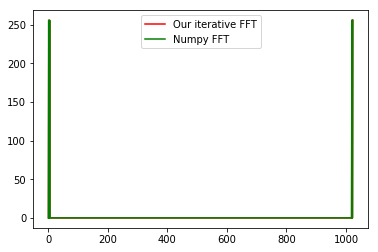

In [81]:
import matplotlib.pyplot as plt
nnn = 1024
cos = (np.cos(2*np.pi*np.arange(nnn)/nnn))/2
sig = cos+1j*(np.cos(8*np.pi*np.arange(nnn)/nnn))/2
plt.plot(np.arange(nnn),np.abs(iterfft_bitorder_in_DIT(sig)),'r',label='Our iterative FFT')
plt.plot(np.arange(nnn),np.abs(np.fft.fft(sig)),'g',label='Numpy FFT')
plt.legend()
plt.show()

Great, so the fft's match (nearly exactly which is why you cannot see red so well).
Now we implement a natural order in, bit-reverse order out iterative DIT fft (as used by MeerKAT). I precomputed the twiddle factors so there is no redundancy in compute, and while this is different to the MeerKAT FPGA implementation (due to memory constraints) it should not cause any discrepancy:

In [32]:
def maketwiddle(N):
    arr = np.zeros(N//2,dtype=np.complex)
    for i in range(N//2):
        arr[i] = np.exp(-2*i*np.pi*1j/N)
    return arr

In [33]:
maketwiddle(8)

array([ 1.00000000e+00+0.j        ,  7.07106781e-01-0.70710678j,
        6.12323400e-17-1.j        , -7.07106781e-01-0.70710678j])

In [88]:
def iterfft_natural_in_DIT(s,w):
    a = np.asarray(s,dtype = np.complex)
    N = a.size                                  #how long is data stream
    pairs_in_group = N//2                       #how many butterfly pairs per group - starts at 1/2*full data length obviously
    num_of_groups = 1                           #number of groups - how many subarrays are there?
    distance = N//2                             #how far between each fft arm?
    while num_of_groups < N:                    #basically iterates through stages
        for k in range(num_of_groups):          #iterate through each subarray
            jfirst = 2*k*pairs_in_group         #index to beginning of a group
            jlast = jfirst + pairs_in_group - 1 #first index plus offset - used to index whole group
            W=w[k]
            for j in range(jfirst, jlast + 1):
                tmp = W*a[j+distance]
                a[j+distance] = a[j]-tmp
                a[j] = a[j]+tmp
        pairs_in_group //=2
        num_of_groups *=2
        distance //=2
    A=bitrevarray(a,N)                          #post bit-reordering
    return A
        

testing as with above.

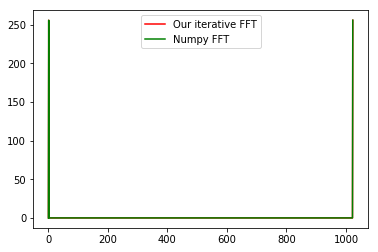

In [89]:
w = maketwiddle(nnn)
w = bitrevarray(w,w.size)
plt.plot(np.abs(iterfft_natural_in_DIT(cos,w)),'r',label='Our iterative FFT')
plt.plot(np.abs(np.fft.fft(cos)),'g',label='Numpy FFT')
plt.legend()
plt.show()

Implementing the fixed point implementation now:

In [36]:
def bitrevfixarray(array,N):
    bits = int(np.log2(N))
    A=array.copy()
    for k in range(0, N):
        A[bit_rev(k,bits)] = array[k]
    return A

And to test:

In [37]:
Data = cfp(4,0,unsigned = True, offset=0.0,method="truncate")
Data.from_complex(np.arange(16))
revData=bitrevfixarray(Data,16) #parse the array [0,1,2,3,4,5,6,7] into the bitreversal array:
print("Type: ",revData,"\n","Data: ",revData.data)

Type:  FP complex unsigned (4, 0), shape (16,) 
 Data:  [ 0.+0.j  8.+0.j  4.+0.j 12.+0.j  2.+0.j 10.+0.j  6.+0.j 14.+0.j  1.+0.j
  9.+0.j  5.+0.j 13.+0.j  3.+0.j 11.+0.j  7.+0.j 15.+0.j]


It works, while maintaining the type and shape of the original data! We now implement the fixed-point FFT with post-bit reordering as with MeerKAT, and implementing the shaping schemes mentioned earlier:

In [38]:
def make_fix_twiddle(N,bits,fraction,offset=0.0, method="round"):
    twids = cfp(bits,fraction,offset = offset, method = method)
    tmp = cfp(bits,fraction,offset=offset, method = method)
    twids.from_complex(np.zeros(N//2,dtype=np.complex))
    for i in range(0,N//2):
        tmp.from_complex(np.exp(-2*i*np.pi*1j/N)/2.001)
        twids[i] = tmp
    return twids

Checking our fixedpoint twiddle factor maker works:

It works, now we may implement the FFT as per the MeerKAT standards (shifting schemes etc).

In [42]:
from collections import deque
import numpy as np
def iterffft_natural_DIT(a,twid,shiftreg,bits,fraction,offset=0.0,method="round"):       #parse in data,tiddle factors (must be in bit reversed order for natural order in),
                                                                                 #how many bits fixpoint numbers are, fraction bits they are, offset, and rounding scheme.
    data=a.copy()
    N = data.data.size                                                           #how long is data stream
    stages = np.log2(N)
    if(type(shiftreg) == deque and len(shiftreg)==stages):
        shiftreg = shiftreg
    elif(type(shiftreg)==list and len(shiftreg)==stages):
        shiftreg = deque(shiftreg)
    else:
        raise ValueError("shift register must be of type list or deque, and its length must be that of log2(data length)")
    
    pairs_in_group = N//2                                                        #how many butterfly pairs per group - starts at 1/2*full data length obviously
    num_of_groups = 1                                                            #number of groups - how many subarrays are there?
    distance = N//2                                                              #how far between each fft arm?
    while num_of_groups < 2:                                                     #basically iterates through stages
        for k in range(num_of_groups):                                           #iterate through each subarray
            jfirst = 2*k*pairs_in_group                                          #index to beginning of a group
            jlast = jfirst + pairs_in_group - 1                                  #first index plus offset - used to index whole group
            W=twid[k]
            for j in range(jfirst,jlast+1):
                tmp = (W * data[j+distance]) >> bits
                tmp.bits -= bits + 1
                tmp.fraction -= bits
                tmp.normalise()
                data[j+distance] = data[j]-tmp
                data[j] = data[j]+tmp
        if shiftreg.pop():                                                   #implement FFT shift and then normalise to correct at end of stage
            data>>1
        pairs_in_group //=2
        num_of_groups *=2
        distance //=2
    A=bitrevfixarray(data,N)                                                        #post bit-reordering
    return A

Testing it on a cosine in a similar way to the floating point instance:

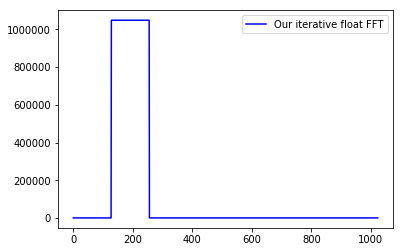

In [79]:
import collections
bits = 20
cos = (np.cos(8*np.pi*np.arange(nnn)/nnn))/8.001
sig = cos+1j*(np.cos(128*np.pi*np.arange(nnn)/nnn))/8.001
fixsig = cfp(bits,bits,offset=0.0,method="truncate")                                             #our cosine will be
fixsig.from_complex(cos)                                                         #get data in
shiftreg = collections.deque([0,0,0,0,1,1,1,1,1,1])                                                #make 64 bit shiftregister
#shiftreg = collections.deque([1,1,1,1,1,1,1,1,1,1])                                                #make 64 bit shiftregister
twiddles = make_fix_twiddle(nnn,bits,bits,method="truncate")                                       #make fixpoint twiddle factors
twiddles = bitrevfixarray(twiddles,twiddles.data.size)                           #reverse order them 
FFFTcos = iterffft_natural_DIT(fixsig,twiddles,shiftreg,bits,bits)                       #perform fixed point fft
absFFFTcos = np.abs(FFFTcos.to_complex())
w = maketwiddle(nnn)
w = bitrevarray(w,w.size)
plt.plot(np.abs(iterfft_natural_in_DIT(cos,w))*2**bits,'b',label='Our iterative float FFT')
#plt.plot(np.abs(np.fft.fft(sig)),'g',label='Numpy FFT')
#plt.plot(absFFFTcos,'r',label='Our iterative fixed FFT')
#plt.ylim(0, absFFFTcos.max()*3)
#plt.xlim(0, 100)
plt.legend()
plt.show()

In [147]:
fixsig.data-bitrevfixarray(bitrevfixarray(fixsig,nnn),nnn).data
  

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

Well... sort of correct spikes, but very small. They must be saturating, because we cannot allow our data to grow past 1 (i.e. we have 1 bit integer part and 9 bits fraction part). Is there some post data scaling at SKA? :/ FFT shifting is still required however, so perhaps that will reduce the inbetween spikes. How to shift? SKA uses a register containing 1's if one should shift a 0's if no shift necessary. Considering we're processing a cosine wave, we should fft shift at every loop for now, but we'll implement the functionality to read from a 'register'. For now, the register will contain only 1's

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PFB object. Initialise with taps, points, percentage of total to average over
and window type. Then parse data set, or parse data stream.
"""
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt

class PFB(object):
        """This function takes point size, how many taps, what percentage of total data to average over,
        what windowing function, whether you're running dual polarisations, and data type"""
        def __init__(self, N, taps, avg = 1, datasrc = None, w = 'hanning',dual = False):
            self.N = N                                      #how many points
            self.avg = avg                                  #what averaging
            self.dual = dual                                #whether you're performing dual polarisations or not
            self.reg =np.zeros([N,taps])                    #our fir register size filled with zeros orignally
            self.inputdata = None
            if(datasrc is not None and type(datasrc)==str):             #if input data file is specified
                self.inputdatadir = datasrc
                self.outputdatadir = datasrc[:-4]+"out.npy"
                self.inputdata  = np.load(datasrc)
                
            
            WinDic = {                                      #dictionary of various filter types
                'hanning' : np.hanning,
                'hamming' : np.hamming,
                'bartlett': np.bartlett,
                'blackman': np.blackman,
                }
            
            self.window=WinDic[w](taps)     
            self.X_k = None                                 #our output
            
            if(dual):                                       #if dual, our two outputs
                self.H_k = None
                self.G_k = None
                
        """Takes data segment (N long) and appends each value to each fir.
        Returns data segment (N long) that is the sum of fircontents*window"""
        def _FIR(self,x):
            X = np.sum(self.reg*self.window,axis=1)              #filter
            self.reg = np.column_stack((x,self.reg))[:,:-1]      #push and pop from FIR register array
            return X
        
        """In the event that that dual polarisations have been selected, we need to 
        split out the data after and return the individual X_k values"""        
        def _split(self,Y_k):
            length = np.size(Y_k,axis=1)
            self.H_k = np.zeros([self.N,length],dtype = np.complex)
            self.G_k = np.ones([self.N,length],dtype=np.complex)
            
            #reverse the arrays for the splitting function correctly
            R_k = np.real(Y_k)
            R_kflip = R_k.copy()
            R_kflip[1:] = R_kflip[1:][::-1]
            
            I_k = np.imag(Y_k)
            I_kflip = I_k.copy()
            I_kflip[1:] = I_kflip[1:][::-1]

            self.G_k[:,:] = (1/2)*(R_k[:,:]+1j*I_k[:,:]+R_kflip[:,:]-1j*I_kflip[:,:])
            self.H_k[:,:] = (1/2j)*(R_k[:,:]+1j*I_k[:,:]-R_kflip[:,:]+1j*I_kflip[:,:])
        
        

        """Here we take the power spectrum of the outputs. The averaging scheme
        tells over what portion of the output data to take the power spectrum of.
        If alternatively a input file is specified, then average specifies over
        how many channels to average."""        
        def _pow(self,X):
            if(self.avg ==1):
                return np.abs(X[:])**2                             #The scheme for averaging used.
            
            elif(abs(self.avg)<1):                                 #If input data array is used
                                                                   #then averaging will be over a % of it.
                iterr = int(1/self.avg)
                rng = X.shape[1]//iterr
                Xt = np.zeros([self.N,iterr])
                for i in range(0,iterr):
                    if(i ==0):
                        Xt[:,i] = np.abs(np.sum(X[:,0:rng],axis=1))**2
                    else:
                        Xt[:,i] = np.abs(np.sum(X[:,i*rng-1:i*rng+rng-1],axis=1))**2
                return Xt
            
            else:                                                   #If input file is used the averaging then
                                                                    #averaging will be over specified # of channels.
                assert X.shape[1]>self.avg and X.shape[1]%self.avg==0, "Data parsed is not enough to average over"
                +"or is not multiple of average specified"
                iterr = X.shape[1]//self.avg
                Xt = np.zeros([self.N,iterr])
                for i in range(0,iterr):
                    if(i==0):
                        Xt[:,i] = np.abs(np.sum(X[:,0:self.avg],axis=1))**2
                    else:
                        Xt[:,i] = np.abs(np.sum(X[:,i*self.avg-1:i*self.avg+self.avg-1],axis=1))**2

        """Given data, (having specified whether the PFB will run in dual or not)
        you parse the data and the PFB will compute the spectrum (continuous data mode to still add)"""
        def run(self,data=None):
            if (data is not None):                                  #if we are using an input data array
                self.inputdata = data
            elif(self.inputdata is None):
                raise ValueError ("No input data for PFB specified.")

            size = len(self.inputdata)                                    #get length of data stream
            stages = size//self.N                               #how many cycles of commutator
            X = np.zeros([self.N,stages],dtype = np.complex)    #will be tapsize x stage
            
            for i in range(0,stages):                           #for each stage, populate all firs, and run FFT once
                if(i ==0):
                    X[:,i] = iterfft(self._FIR(self.inputdata[i*self.N:i*self.N+self.N]))
                else:
                    X[:,i] = iterfft(self._FIR(self.inputdata[i*self.N-1:i*self.N+self.N-1]))
            
            if(type(self.inputdata) == str):             
                if(self.dual): 
                    self._split(X)
                    np.save(self.outputdatadir,self._pow(self.G_k)+1j*self._pow(self.H_k))          #save output data as complex (same pol ordering)
                    
                else:   
                    np.save(self.outputdatadir,self._pow(X))
            else:
                if(self.dual): 
                    self._split(X)
                    self.G_k=self._pow(self.G_k)
                    self.H_k=self._pow(self.H_k)
                else:
                    self.X_k = self._pow(X)
                    

        """Plotting method to display the spectrum - has option to display input alongside"""
        def show(self,save=False,flnm = 'plot.png'):
            n = np.arange(self.N)
            if(type(self.inputdata) == str):         #In the event we are writing to
                                                    #and reading from a file.
                if(self.dual):
                    Val = np.load(self.outputdatadir)
                    fig = plt.figure(1)
                    plt.subplot(211)
                    plt.plot(n,np.real(Val))
                
                    plt.subplot(212)
                    plt.plot(n,np.imag(Val))
                    if(save): fig.savefig(flnm)
                    plt.show()
                    
                else:
                    Val = np.load(self.outputdatadir)
                    fig = plt.plot(n,Val)
                    if(save): fig.savefig(flnm)
                    plt.show()
            else:                                   #In the event we were given
                                                    #a direct array.
                if(self.dual):
                    fig = plt.figure(1)
                    plt.subplot(211)
                    plt.plot(n,self.H_k)
                
                    plt.subplot(212)
                    plt.plot(n,self.G_k)
                    if(save): fig.savefig(flnm)
                    plt.show()
                    
                else:
                    fig = plt.plot(n,self.X_k)
                    if(save): fig.savefig(flnm)
                    plt.show()

Taking a cos input signal:

In [ ]:
cos = np.cos(160*np.pi*np.arange(1280)/1280)
plt.plot(np.arange(1280),cos)
plt.title('Cos input signal')

Say we want to process the above signal using a 64-pt, 4 tap pfb that averages over 4 output channels, and accepts a single polarisation. We'd declare this pfb as:

In [ ]:
pfb_float_single = PFB(64,4,0.25)

and run the data through it and display it as:

In [ ]:
pfb_float_single.run(cos)
pfb_float_single.show()

And showing the last output of our pfb (so as to see an output without averaging):

In [ ]:
plt.plot(np.arange(64),pfb_float_single.X_k[:,-1],'k')

Comparing the above with the numpy transform of a cosine wave we get:

In [ ]:
plt.plot(np.arange(64),np.absolute(np.fft.fft(np.cos(8*np.pi*np.arange(64)/64)))[:]**2,'k')

Which produces spikes in the same places, but just of lower amplitude due to numpy operating on a 20th of the data.
Checking a dual polarisation - i.e the following signal:

In [ ]:
rect = np.zeros(1280)
rect[1:10]=1
sig = cos+1j*rect

Which is the combination of a rectangular and cosine function. We declare as:

In [ ]:
pfb_float_dual = PFB(64,4,0.25,dual = True)

In [ ]:
pfb_float_dual.run(sig)
pfb_float_dual.show()

The splitting and averaging works like a charm :').

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 12 14:54:57 2018

@author: User
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PFB object. Initialise with taps, points, percentage of total to average over
and window type. Then parse data set, or parse data stream.
"""
#IMPORTS
import numpy as np
from collections import deque
import collections
import matplotlib.pyplot as plt
from fixpoint import fixpoint, cfixpoint

class FixPFB(object):
        """This function takes point size, how many taps, what percentage of total data to average over,
        what windowing function, whether you're running dual polarisations, and data type"""
        def __init__(self, N, taps, bits, fraction,shiftreg, unsigned = False, offset = 0.5,method = "round",  avgperc = 1,w = 'hanning',dual = False):
            self.N = N                   #how many points
            self.avg = avgperc           #what averaging
            self.dual = dual             #whether you're performing dual polarisations or not
            
            self.bits = bits
            self.fraction = fraction
            self.shiftreg = shiftreg
            self.unsigned = unsigned
            self.offset = offset
            self.method = method
            
            self.reg = cfixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
            self.reg.from_complex(np.zeros([N,taps])) #our fir register size filled with zeros orignally
            
            WinDic = {                   #dictionary of various filter types
                'hanning' : np.hanning,
                'hamming' : np.hamming,
                'bartlett': np.bartlett,
                'blackman': np.blackman,
                }
            self.window = cfixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
            self.window.from_complex(WinDic[w](taps))     
            self.X_k = cfixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)                 #our output
            
            if(dual):                       #if dual, our two outputs
                self.H_k = cfixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
                self.G_k = cfixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
                
        """Takes data segment (N long) and appends each value to each fir.
        Returns data segment (N long) that is the sum of fircontents*window"""
        def _FIR(self,x):
            X =  (self.reg*self.window).sum(axis=1).quantise(self.bits,self.fraction,unsigned=self.unsigned)
            tmp = np.column_stack((x.data,self.reg.data))[:,:-1]
            self.reg.real.data = np.real(tmp)
            self.reg.imag.data = np.imag(tmp)     #push and pop from FIR register array
            return X
        
        """In the event that that dual polarisations have been selected, we need to 
        split out the data after and return the individual X_k values"""        
        def _split(self,Yk):
            length = np.size(Yk.data,axis=1)
            self.H_k.from_complex(np.zeros([self.N,length]))
            self.G_k.from_complex(np.zeros([self.N,length]))
            
            zeros = np.zeros(Yk.data.shape)
            tmpfx = fixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
            tmpfx.from_float(zeros)
            
            R_k = cfixpoint(real=Yk.real,imag = tmpfx)
            I_k = cfixpoint(real = tmpfx,imag = Yk.imag)
            
            R_kflip = R_k.copy()
            R_kflip[1:] = R_kflip[1:][::-1]
            
            I_kflip = I_k.copy()
            I_kflip[1:] = I_kflip[1:][::-1]
            
            cst2 = cfixpoint(1, 0,unsigned = self.unsigned,offset = self.offset, method = self.method)
            cst3 = cfixpoint(1, 0,unsigned = self.unsigned,offset = self.offset, method = self.method)
            cst2.from_complex(-1j)
            cst3.from_complex(1)

            self.G_k[:,:] = (R_k[:,:]+cst2*I_k[:,:]+R_kflip[:,:]-cst2*I_kflip[:,:]).r_shift(1)
            self.H_k[:,:] = (cst3*cst2*(R_k[:,:]+cst2*I_k[:,:]-R_kflip[:,:]+cst2*I_kflip[:,:])).r_shift(1)

        

        """Here we take the power spectrum of the outputs. The averaging scheme
        tells over what portion of the output data to take the power spectrum of."""        
        def _pow(self,X):
            if(self.avg ==1):
                retX = X.real*X.real + X.imag*X.imag
                return retX
            else:
                iterr = int(1/self.avg)
                rng = len(X.data[0,:])//iterr
                Xt = fixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
                Xt.from_float(np.zeros([self.N,iterr]))
                for i in range(0,iterr):
                    if(i ==0):
                        xt = X[:,i*rng:i*rng+rng].sum(axis=1)
                        Xt[:,i] = xt.real*xt.real+xt.imag*xt.imag
                    else:
                        xt = X[:,i*rng-1:i*rng+rng-1].sum(axis=1)
                        Xt[:,i] = xt.real*xt.real+xt.imag*xt.imag
                return Xt

        """Given data, (having specified whether the PFB will run in dual or not)
        you parse the data and the PFB will compute the spectrum (continuous data mode to still add)"""
        def run(self,DATA, cont = False):
            if (cont ==False):
                    size = DATA.data.shape[0]                           #get length of data stream
                    stages = size//self.N                               #how many cycles of commutator
                    
                    X = cfixpoint(self.bits, self.fraction,unsigned = self.unsigned,offset = self.offset, method = self.method)
                    X.from_complex(np.zeros([self.N,stages]))           #will be tapsize x stage
                    
                    for i in range(0,stages):                           #for each stage, populate all firs, and run FFT once
                        if(i ==0):
                            X[:,i] = iterffft(self._FIR(DATA[i*self.N:i*self.N+self.N]),self.bits,self.fraction,self.shiftreg)
                        else:
                            X[:,i] = iterffft(self._FIR(DATA[i*self.N-1:i*self.N+self.N-1]),self.bits,self.fraction,self.shiftreg)
                    if(self.dual): 
                        self._split(X)
                        self.H_k = self._pow(self.H_k)
                        self.G_k = self._pow(self.G_k)
                    else:   
                        self.X_k = self._pow(X)
            else:
                pass

        """Plotting method to display the spectrum - has option to display input alongside"""
        def show(self,save=False,flnm = 'plot.png'):
            n = np.arange(self.N)
            if(self.dual):
                fig = plt.figure(1)
                plt.subplot(211)
                plt.plot(n,self.H_k.to_float())
            
                plt.subplot(212)
                plt.plot(n,self.G_k.to_float())
                if(save): fig.savefig(flnm)
                
            else:
                fig = plt.plot(n,self.X_k.to_float())
                if(save): fig.savefig(flnm)
                

The above PFB is implemented to take a cfixpoint data stream, and operate on it. The bits and fraction integers specified determine what precision the output data, window factors and data stored in the FIR registers is kept at. The same goes for the specifying of the offset, rounding method and unsigned. Below we mimick the test run on the floating point PFB with 8 bits, 7 fraction, and signed numbers. We also specify the shift register for the FFT to be all 1's and so we shift right on every iteration.

In [ ]:
fixcos = cfixpoint(8,7)
fixcos.from_complex(cos)
reg = deque([1,1,1,1,1,1])
fpfb = FixPFB(N=64,taps=4,bits=10,fraction=9,shiftreg = reg)
fpfb.run(fixcos)
fpfb.show()

Yaaay! I think.

Checking dual polarisations now, without averaging:

In [ ]:
csig=cfixpoint(8,7)
csig.from_complex(sig) #get out complex signal - same as earlier test
fpfbdual = FixPFB(N=64,taps=4,bits=10,fraction=9,shiftreg = reg, dual=True, avgperc = 0.25)
fpfbdual.run(csig)
fpfbdual.show()